## Import libs

In [ ]:
# Install if tf is not installed
!pip install -q tensorflow

In [1]:
import tensorflow as tf
import pathlib
import PIL

import matplotlib.pyplot as plt
import numpy as np
import cv2

## Read dataset path

In [2]:
# Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/capstone/ml/guitars'

In [4]:
data_dir = pathlib.Path(dataset_path)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

538


## Show samples

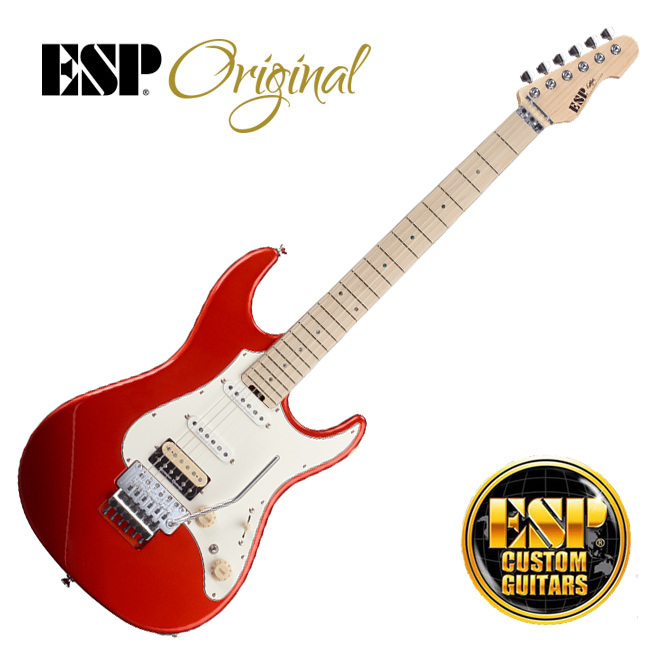

In [11]:
sample_strat = list(data_dir.glob('Stratocaster/*'))
PIL.Image.open(str(sample_strat[0]))

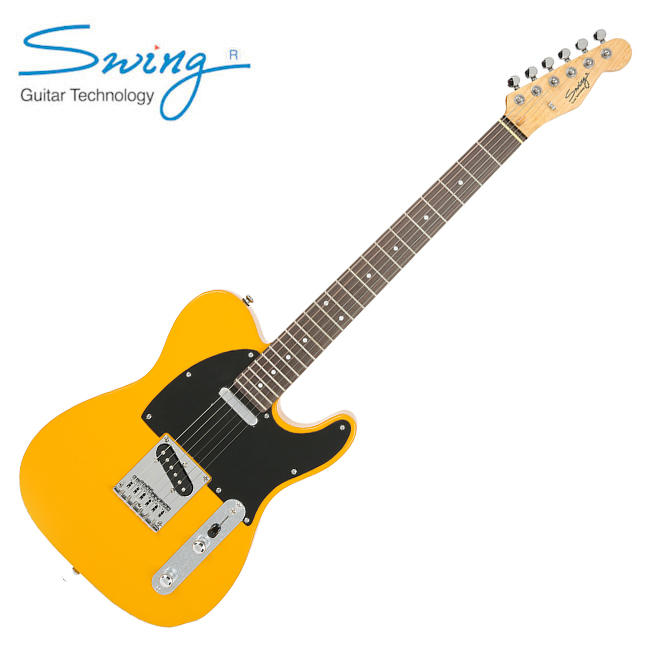

In [7]:
sample_tele = list(data_dir.glob('Telecaster/*'))
PIL.Image.open(str(sample_tele[0]))

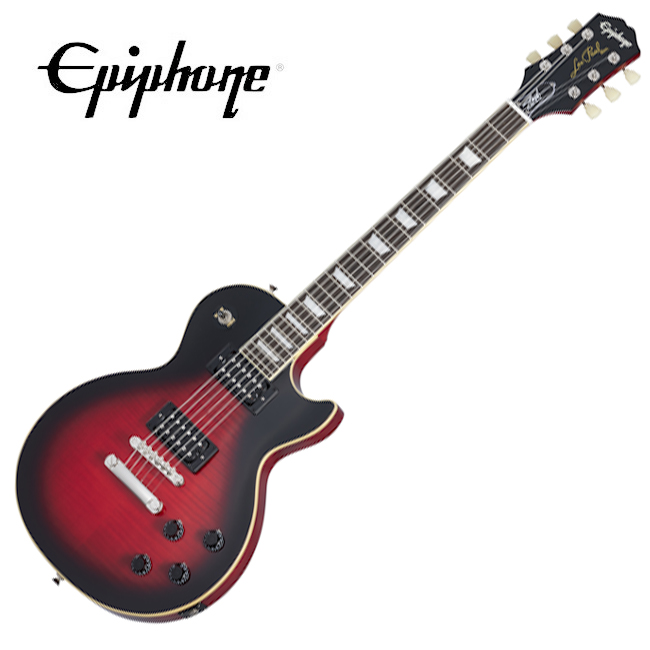

In [8]:
sample_lespaul = list(data_dir.glob('LesPaul/*'))
PIL.Image.open(str(sample_lespaul[0]))

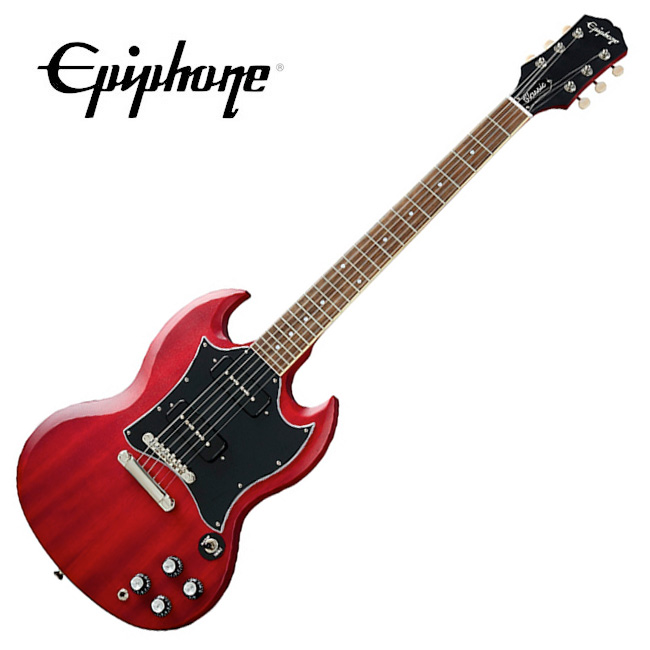

In [9]:
sample_sg = list(data_dir.glob('SG/*'))
PIL.Image.open(str(sample_sg[0]))

## Load images

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             rescale=1. / 255,
                             validation_split=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             zoom_range=[1.0, 1.2])

train_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/capstone/ml/guitars',
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

val_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/capstone/ml/guitars',
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 439 images belonging to 4 classes.
Found 107 images belonging to 4 classes.


In [8]:
print(train_gen.class_indices)
class_names = {val: key for key, val in train_gen.class_indices.items()}
print(class_names)

{'LesPaul': 0, 'SG': 1, 'Stratocaster': 2, 'Telecaster': 3}
{0: 'LesPaul', 1: 'SG', 2: 'Stratocaster', 3: 'Telecaster'}


## Show loaded images

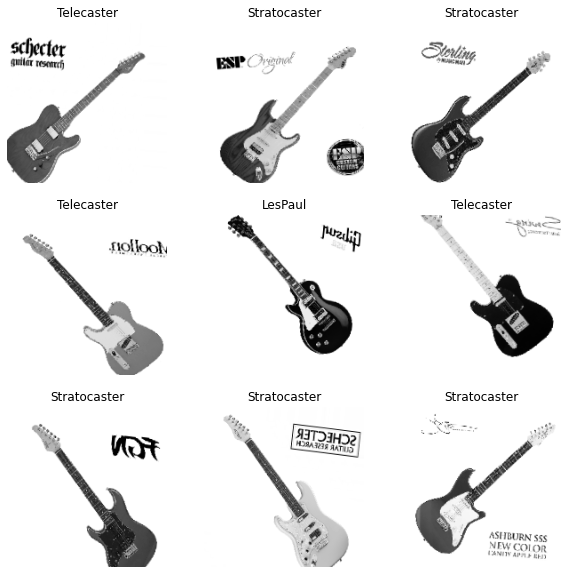

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img, label = train_gen.next()
    plt.imshow(img[i][:,:,0], cmap='gray')
    plt.title(class_names[np.argmax(label[i])])
    plt.axis('off')

In [10]:
for image_batch, labels_batch in train_gen:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 1)
(32, 4)


In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Build model

In [19]:
num_classes = 4

model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu',
                input_shape=(img_height, img_width, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile model

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Show model summary

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 107584)           

## Train model

In [22]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, acc_threshold=1.0, val_threshold=1.0):
        self.acc_threshold = acc_threshold
        self.val_threshold = val_threshold
    def on_epoch_end(self, epoch, logs=None):
        acc = logs['accuracy']
        val_acc = logs['val_accuracy']
        if acc >= self.acc_threshold and val_acc >= self.val_threshold:
            self.model.stop_training = True

In [25]:
epochs=500
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[CustomCallback(acc_threshold=0.99, val_threshold=0.95)]
)

Epoch 1/500
14/14 [==============================] - 8s 584ms/step - loss: 1.1134 - accuracy: 0.5034 - val_loss: 1.1002 - val_accuracy: 0.5421
Epoch 2/500
14/14 [==============================] - 8s 543ms/step - loss: 1.0141 - accuracy: 0.5718 - val_loss: 0.9481 - val_accuracy: 0.5794
Epoch 3/500
14/14 [==============================] - 7s 532ms/step - loss: 1.0249 - accuracy: 0.5923 - val_loss: 1.0487 - val_accuracy: 0.5327
Epoch 4/500
14/14 [==============================] - 7s 532ms/step - loss: 1.0051 - accuracy: 0.5809 - val_loss: 0.9696 - val_accuracy: 0.6075
Epoch 5/500
14/14 [==============================] - 7s 538ms/step - loss: 0.9397 - accuracy: 0.6310 - val_loss: 0.9428 - val_accuracy: 0.5794
Epoch 6/500
14/14 [==============================] - 7s 534ms/step - loss: 0.8875 - accuracy: 0.6355 - val_loss: 0.9056 - val_accuracy: 0.6449
Epoch 7/500
14/14 [==============================] - 7s 534ms/step - loss: 0.8281 - accuracy: 0.6651 - val_loss: 0.7829 - val_accuracy: 0.6729

## Visualize result

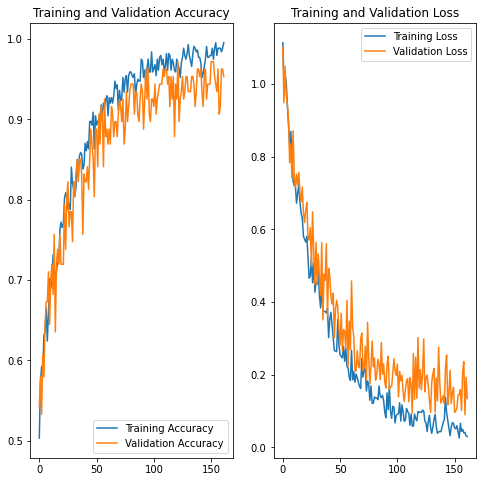

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(162)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [29]:
!pip install -q tensorflowjs

     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 462 kB 25.9 MB/s 


In [30]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/capstone/ml/tfjs_model')